In [ ]:
from google.colab import drive
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchaudio
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import librosa.display
import soundfile as sf  # pip install soundfile

# Mount Google Drive
drive.mount('/content/drive')

# Path to the folder containing the sound dataset
dataset_folder = '/content/drive/MyDrive/fold2'

# Change the current working directory to the dataset folder
os.chdir(dataset_folder)

import glob

clean_wavs_path = glob.glob('/content/drive/MyDrive/clean_testset_wav/*.wav')
noisy_wavs_path = glob.glob('/content/drive/MyDrive/fold2/*.wav')

class config:
    target_sample_rate=48000
    duration=4
    n_fft=1024
    hop_length=512
    n_mels=64
    batch_size=8
    learning_rate=1e-5
    epochs= 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, clean_data_path, noisy_data_path, transform=None,
                 target_sample_rate=config.target_sample_rate, duration=config.duration):
        self.root_clean = clean_data_path
        self.root_noisy = noisy_data_path
        self.transform = transform
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate*duration

    def __len__(self):
        return len(self.root_clean)

    def __getitem__(self, index):
        audio_path_clean = self.root_clean[index]
        audio_path_noisy = self.root_noisy[index]

        signal, sr = torchaudio.load(audio_path_clean)
        signal_noisy, sr_noisy = torchaudio.load(audio_path_noisy)
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
            signal_noisy = resampler(signal_noisy)

        if signal.shape[0] > 1:
            signal = torch.mean(signal, axis=0, keepdim=True)

        if signal_noisy.shape[0] > 1:
            signal_noisy = torch.mean(signal_noisy, axis=0, keepdim=True)

        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        if signal_noisy.shape[1] > self.num_samples:
            signal_noisy = signal_noisy[:, :self.num_samples]

        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            signal = F.pad(signal, (0, num_missing_samples))

        if signal_noisy.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal_noisy.shape[1]
            signal_noisy = F.pad(signal_noisy, (0, num_missing_samples))

        mel = self.transform(signal)
        mel_noisy = self.transform(signal_noisy)

        # Normalize the signals
        signal = normalize_signal(signal)
        signal_noisy = normalize_signal(signal_noisy)

        return mel, mel_noisy

def normalize_signal(signal):
    signal = signal / torch.max(torch.abs(signal))
    return signal

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.target_sample_rate,
                                                      n_fft=config.n_fft,
                                                      hop_length=config.hop_length,
                                                      n_mels=config.n_mels)

# Define the model architecture (UNetGenerator class remains the same)

Mounted at /content/drive


In [ ]:
len(clean_wavs_path)

824

In [ ]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, chnls_in=1, chnls_out=1):
        super(UNetGenerator, self).__init__()
        self.down_conv_layer_1 = DownConvBlock(chnls_in, 64, norm=False)
        self.down_conv_layer_2 = DownConvBlock(64, 128)
        self.down_conv_layer_3 = DownConvBlock(128, 256)
        self.down_conv_layer_4 = DownConvBlock(256, 256, dropout=0.1)
        self.down_conv_layer_5 = DownConvBlock(256, 256, dropout=0.1)
        self.down_conv_layer_6 = DownConvBlock(256, 256, dropout=0.1)

        self.up_conv_layer_1 = UpConvBlock(256, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5)# 256+256 6 5 kernel_size=(2, 3), stride=2, padding=0
        self.up_conv_layer_2 = UpConvBlock(512, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5) # 256+256 1 4
        self.up_conv_layer_3 = UpConvBlock(512, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5) # 2 3
        self.up_conv_layer_4 = UpConvBlock(512, 128, dropout=0.1) # 3 2
        self.up_conv_layer_5 = UpConvBlock(256, 64) # 4 1
        self.up_conv_layer_6 = UpConvBlock(512, 128)
        self.up_conv_layer_7 = UpConvBlock(256, 64)
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_1 = nn.Conv2d(128, chnls_out, 4, padding=1)
        self.activation = nn.Tanh()

    def forward(self, x):
        #print('x', x.shape)
        enc1 = self.down_conv_layer_1(x) # [4, 64, 32, 188]
        print('1', enc1.shape)
        enc2 = self.down_conv_layer_2(enc1) # [4, 128, 16, 94]
        print('2', enc2.shape)
        enc3 = self.down_conv_layer_3(enc2) # [4, 256, 8, 47]
        print('3', enc3.shape)
        enc4 = self.down_conv_layer_4(enc3) # [4, 256, 4, 23]
        print('4', enc4.shape)
        enc5 = self.down_conv_layer_5(enc4) # [4, 256, 2, 11]
        print('5', enc5.shape)
        enc6 = self.down_conv_layer_6(enc5) # [4, 256, 1, 5]
        #print('6', enc6.shape)

        dec1 = self.up_conv_layer_1(enc6, enc5)# enc6: 256 + enc5: 256 [4, 512, 2, 11]
        #print('d1', dec1.shape)
        dec2 = self.up_conv_layer_2(dec1, enc4)# enc4: 256 + dec1=enc5*2: [4, 512, 4, 23]
        #print('d2', dec2.shape)
        dec3 = self.up_conv_layer_3(dec2, enc3)# enc3: 256 + dec2=enc4*2: [4, 512, 8, 47]
        #print('d3', dec3.shape)
        dec4 = self.up_conv_layer_4(dec3, enc2)# enc2: 128 + dec3=enc3*2: [4, 256, 16, 94]
        #print('d4', dec4.shape)
        dec5 = self.up_conv_layer_5(dec4, enc1)# enc1: 64 + dec4=enc1*2: [4, 128, 32, 188]
        #print('d5', dec5.shape)

        final = self.upsample_layer(dec5)
        final = self.zero_pad(final)
        final = self.conv_layer_1(final)
        #print(final.shape)
        return final

class UpConvBlock(nn.Module):
  def __init__(self, ip_sz, op_sz, kernel_size=4, stride= 2, padding=1 ,dropout=0.0):
    super(UpConvBlock, self).__init__()
    self.layers = [
    nn.ConvTranspose2d(ip_sz, op_sz, kernel_size=kernel_size, stride=stride, padding=padding),
    nn.InstanceNorm2d(op_sz),
    nn.ReLU(),
    ]
    if dropout:
      self.layers += [nn.Dropout(dropout)]

  def forward(self, x, enc_ip):
    x = nn.Sequential(*(self.layers))(x)
        #print('x', x.shape)
        #print('enc', enc_ip.shape)
    op = torch.cat((x, enc_ip), 1)
    return op


class DownConvBlock(nn.Module):
  def __init__(self, ip_sz, op_sz, kernel_size=4, norm=True, dropout=0.0):
    super(DownConvBlock, self).__init__()
    self.layers = [nn.Conv2d(ip_sz, op_sz, kernel_size, 2, 1)]
    if norm:
      self.layers.append(nn.InstanceNorm2d(op_sz))
      self.layers += [nn.LeakyReLU(0.2)]
    if dropout:
      self.layers += [nn.Dropout(dropout)]
  def forward(self, x):
    op = nn.Sequential(*(self.layers))(x)
    return op

model = UNetGenerator()

In [ ]:
from tqdm import tqdm

def train(dataloader, model, epoch, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, (clean, noisy) in enumerate(tqdm(dataloader)):
        # clean = clean.to(device)
        # noisy = noisy.to(device)

        optimizer.zero_grad()
        pred = model(noisy)
        curr_loss = loss_fn(pred, clean)
        curr_loss.backward()
        optimizer.step()

        total_loss += curr_loss
        if i % 1000 == 0:
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, total_loss / 200))
            total_loss = 0.0

def val(dataloader, model, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for i, (clean, noisy) in enumerate(dataloader):
            # clean, noisy = clean.to(device), noisy.to(device)
            output = model(noisy)
            loss = loss_fn(output, clean)
            total_loss += loss.item()
            num_batches += 1

    average_loss = total_loss / num_batches
    print(f'Validation Loss after Epoch {epoch + 1}: {average_loss:.4f}')
    return average_loss


In [ ]:

# Initialize the dataset and dataloader
test_clean = clean_wavs_path[:20]
test_noisy = noisy_wavs_path[:20]

training_dataset = CustomDataset(clean_wavs_path[20:800], noisy_wavs_path[20:800], mel_spectrogram)
validation_dataset = CustomDataset(clean_wavs_path[800:], noisy_wavs_path[800:], mel_spectrogram)

trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
validloader = DataLoader(validation_dataset, batch_size=config.batch_size)

# Initialize the model, optimizer, loss function, and learning rate scheduler
model = UNetGenerator()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.L1Loss()  # MAE Loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)

#scheduler = torch.optim

In [ ]:
for epoch in range(config.epochs):
    train(trainloader, model, epoch, loss_fn, optimizer, device)
    val_loss = val(validloader, model, epoch, loss_fn, device)
    scheduler.step(val_loss)

  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:04<07:10,  4.44s/it]

[Epoch number : 1, Mini-batches:     1] loss: 0.091
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:08<06:51,  4.28s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:10<05:15,  3.32s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:12<04:18,  2.75s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:14<03:57,  2.55s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:16<03:32,  2.31s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:18<03:24,  2.25s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:21<03:31,  2.35s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:24<03:36,  2.44s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:25<03:18,  2.26s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:27<03:07,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:29<02:57,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:31<02:50,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:33<02:51,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:36<03:01,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:38<02:58,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:40<02:48,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:42<02:40,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:43<02:34,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:45<02:30,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:47<02:29,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:50<02:41,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:52<02:41,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:54<02:32,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:56<02:26,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:58<02:21,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:59<02:17,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [01:01<02:14,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [01:04<02:25,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:06<02:28,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:08<02:20,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:10<02:14,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:12<02:09,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:14<02:04,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:16<02:00,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:18<02:08,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:20<02:12,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:22<02:04,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:24<01:58,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:26<01:54,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:28<01:50,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:30<01:46,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:32<01:52,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:35<02:02,  2.27s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:37<01:53,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:39<01:46,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:40<01:41,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:42<01:37,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:44<01:34,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:46<01:37,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:49<01:42,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:51<01:38,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:53<01:35,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:55<01:29,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:57<01:25,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:59<01:21,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [02:01<01:24,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [02:03<01:27,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:05<01:20,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:07<01:16,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:09<01:12,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:11<01:09,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:13<01:06,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:15<01:07,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:17<01:10,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:19<01:07,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:21<01:02,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:23<00:59,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:25<00:55,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:27<00:52,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:29<00:52,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:31<00:54,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:33<00:53,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:35<00:48,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:37<00:45,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:39<00:42,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:41<00:39,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:42<00:37,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:45<00:38,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:47<00:38,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:49<00:34,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:51<00:31,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:53<00:28,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:54<00:26,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:56<00:24,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:59<00:23,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [03:01<00:23,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [03:03<00:20,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [03:05<00:17,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:07<00:15,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:08<00:13,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:10<00:11,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:12<00:09,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:15<00:08,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:17<00:06,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:19<00:04,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:21<00:01,  1.97s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:22<00:00,  2.06s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 1: 8.6855


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:45,  1.71s/it]

[Epoch number : 2, Mini-batches:     1] loss: 0.082
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:16,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:30,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:12,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:00,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:52,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:45,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:42,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:44,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:58,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:59,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:49,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:40,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:36,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:32,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:29,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:34,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:42,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:39,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:31,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:24,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:19,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:43<02:16,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:45<02:13,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:23,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:27,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:19,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:53<02:13,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:55<02:08,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:57<02:02,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:58<01:58,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:00<02:00,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:03<02:09,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<02:09,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:07<02:02,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:08<01:55,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:10<01:50,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:12<01:48,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:14<01:46,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:16<01:50,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:18<01:57,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:20<01:51,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:22<01:44,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:23<01:39,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:25<01:35,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:27<01:31,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:29<01:28,  1.74s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:31<01:33,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:33<01:39,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:35<01:35,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:37<01:29,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:38<01:25,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:40<01:22,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:42<01:18,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:44<01:17,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:46<01:22,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:48<01:22,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:50<01:17,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:52<01:13,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:54<01:10,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:55<01:06,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [01:57<01:04,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [01:59<01:05,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:01<01:09,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:03<01:06,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:05<01:02,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:07<00:58,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:09<00:54,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:10<00:52,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:12<00:50,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:14<00:51,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:17<00:52,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:18<00:49,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:20<00:46,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:22<00:43,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:24<00:41,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:26<00:39,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:28<00:38,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:30<00:39,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:32<00:37,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:34<00:34,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:36<00:31,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:38<00:28,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:40<00:26,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:41<00:24,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:44<00:24,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:46<00:23,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:48<00:20,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:50<00:17,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:52<00:15,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:54<00:13,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:55<00:11,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [02:58<00:09,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:00<00:08,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:02<00:06,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:04<00:03,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:06<00:01,  1.93s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:07<00:00,  1.91s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 2: 8.3192


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:41,  1.66s/it]

[Epoch number : 3, Mini-batches:     1] loss: 0.077
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:13,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:24,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<03:06,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:56,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:50,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:46,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:14<02:42,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:45,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:57,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:55,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:46,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:40,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:35,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:30,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:26,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:34,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:44,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:38,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:29,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:24,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:41<02:19,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:43<02:15,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:45<02:14,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:47<02:25,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:27,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:51<02:19,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:53<02:12,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:55<02:07,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:57<02:04,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:58<02:00,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:00<02:04,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:03<02:12,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<02:10,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:07<02:03,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<02:01,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<02:09,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<02:07,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<02:06,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<02:08,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<02:00,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:52,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:45,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:41,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:37,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:28<01:34,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:31<01:41,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:33<01:43,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:36,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:37<01:31,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:38<01:27,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:40<01:24,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:42<01:21,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:44<01:23,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:46<01:27,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:48<01:24,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:50<01:19,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:52<01:15,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:11,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:55<01:08,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:57<01:06,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [01:59<01:09,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:02<01:11,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:03<01:07,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:05<01:03,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:07<00:59,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:09<00:56,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:10<00:54,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:12<00:53,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:15<00:56,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:17<00:54,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:19<00:50,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:20<00:47,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:22<00:44,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:24<00:41,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:26<00:39,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:28<00:40,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:30<00:41,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:32<00:38,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:34<00:34,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:36<00:32,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:37<00:29,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:39<00:27,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:41<00:25,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:43<00:25,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:46<00:24,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:47<00:21,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:49<00:19,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:51<00:16,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:53<00:14,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:54<00:12,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:56<00:11,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [02:59<00:10,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:01<00:08,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:03<00:05,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:04<00:03,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:06<00:01,  1.85s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:07<00:00,  1.91s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 3: 8.0985


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:25,  2.12s/it]

[Epoch number : 4, Mini-batches:     1] loss: 0.075
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:31,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:15,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:59,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:51,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:47,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:43,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:14<02:40,  1.78s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:53,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<03:02,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:52,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:45,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:38,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<03:16,  2.34s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:32<03:58,  2.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:36<04:19,  3.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:38<03:51,  2.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:40<03:24,  2.55s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:42<03:04,  2.33s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:43<02:49,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:45<02:39,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:47<02:35,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:50<02:44,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:52<02:41,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:54<02:31,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:56<02:23,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:57<02:17,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:59<02:13,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [01:01<02:09,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:03<02:16,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:06<02:23,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:08<02:14,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:09<02:08,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:11<02:03,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:13<01:58,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:15<01:55,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:17<01:59,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:19<02:06,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:22<02:03,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:23<01:56,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:25<01:51,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:27<01:47,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:29<01:43,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:31<01:44,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:33<01:50,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:35<01:49,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:37<01:42,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:39<01:37,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:41<01:33,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:43<01:30,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:44<01:27,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:47<01:32,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:49<01:35,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:51<01:29,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:53<01:24,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:55<01:20,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:57<01:17,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:58<01:14,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:01<01:16,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:03<01:20,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:05<01:16,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:07<01:11,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:09<01:07,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:10<01:04,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:12<01:01,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:14<01:00,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:17<01:03,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:19<01:02,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:21<00:57,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:22<00:54,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:24<00:51,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:26<00:48,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:28<00:45,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:30<00:46,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:32<00:48,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:34<00:44,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:36<00:41,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:38<00:38,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:40<00:35,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:41<00:33,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:43<00:32,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:46<00:32,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:48<00:31,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:50<00:27,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:51<00:24,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:53<00:22,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:55<00:20,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:57<00:18,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:59<00:17,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:02<00:17,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:03<00:14,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:05<00:11,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:07<00:09,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:09<00:07,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:11<00:05,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:13<00:04,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:16<00:02,  2.18s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:17<00:00,  2.01s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 4: 7.9440


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:41,  1.67s/it]

[Epoch number : 5, Mini-batches:     1] loss: 0.073
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:39,  1.66s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:38,  1.67s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:06<02:40,  1.71s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:58,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<03:12,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<03:03,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:55,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:48,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:43,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:40,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:22<02:44,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:55,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:53,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:44,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:37,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:32,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:28,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:24,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:34,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:42,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:32,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:26,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:46<02:20,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:47<02:16,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:49<02:13,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:51<02:18,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:26,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:23,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:15,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:59<02:09,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:01<02:04,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:03<02:00,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<01:58,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:07<02:06,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<02:10,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<02:02,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<01:55,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<01:51,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:17<01:47,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:18<01:44,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:47,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:53,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:50,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:44,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:39,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:30<01:35,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:32<01:32,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:34<01:30,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:36<01:36,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:39<01:37,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:40<01:31,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:42<01:26,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:44<01:22,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:46<01:19,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:47<01:16,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:50<01:19,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:52<01:23,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:19,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:56<01:14,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:58<01:10,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [01:59<01:07,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:01<01:04,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:03<01:02,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:05<01:06,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:08<01:06,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:09<01:01,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:11<00:57,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:13<00:54,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:15<00:51,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:17<00:49,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:19<00:50,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:21<00:52,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:23<00:49,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:25<00:45,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:27<00:42,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:29<00:40,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:31<00:38,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:33<00:37,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:35<00:38,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:37<00:36,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:39<00:32,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:41<00:29,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:43<00:27,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:45<00:26,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:48<00:25,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:50<00:24,  2.26s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:52<00:21,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:54<00:18,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:56<00:16,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:58<00:13,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:59<00:11,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:02<00:09,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:04<00:08,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:06<00:06,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:08<00:04,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:10<00:01,  1.97s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:11<00:00,  1.95s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 5: 7.8324


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:54,  1.80s/it]

[Epoch number : 6, Mini-batches:     1] loss: 0.071
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:17,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:29,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:11,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:00,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:50,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:45,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:40,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:42,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:54,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:58,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:48,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:41,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:35,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:31,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:27,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:34,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:44,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:40,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:31,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:25,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:20,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:43<02:16,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:45<02:13,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:25,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:29,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:20,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:53<02:14,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:55<02:09,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:57<02:05,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:59<02:01,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:01<02:07,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:03<02:14,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<02:11,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:07<02:03,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<01:58,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<01:53,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:12<01:49,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:14<01:47,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:17<01:55,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:19<01:59,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:51,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:22<01:45,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:24<01:41,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:26<01:37,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:28<01:34,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:30<01:37,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:32<01:42,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:34<01:40,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:36<01:33,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:38<01:29,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:39<01:25,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:41<01:22,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:43<01:19,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:45<01:24,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:48<01:28,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:49<01:22,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:51<01:17,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:53<01:13,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:55<01:10,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:57<01:07,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [01:59<01:08,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:01<01:11,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:03<01:09,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:05<01:04,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:07<01:00,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:08<00:58,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:10<00:55,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:12<00:52,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:14<00:54,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:16<00:55,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:18<00:52,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:20<00:48,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:22<00:45,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:24<00:42,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:25<00:40,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:27<00:39,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:30<00:40,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:32<00:38,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:34<00:35,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:35<00:32,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:37<00:29,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:39<00:27,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:41<00:25,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:43<00:25,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:45<00:24,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:47<00:22,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:49<00:19,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:51<00:16,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:52<00:14,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:54<00:12,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:56<00:10,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [02:58<00:09,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:01<00:08,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:02<00:05,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:04<00:03,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:06<00:01,  1.86s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:07<00:00,  1.91s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 6: 7.7521


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:56,  1.82s/it]

[Epoch number : 7, Mini-batches:     1] loss: 0.070
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:18,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:19,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:59,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:48,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:42,  1.76s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:12<02:38,  1.74s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:14<02:34,  1.72s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:33,  1.73s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:46,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:52,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:22<02:42,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:35,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:25<02:29,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:27<02:24,  1.74s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:29<02:20,  1.72s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:30<02:20,  1.73s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:33<02:30,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:35<02:35,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:36<02:25,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:38<02:19,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:40<02:13,  1.76s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:41<02:09,  1.73s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:43<02:06,  1.71s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:45<02:04,  1.70s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:47<02:14,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:49<02:20,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:51<02:11,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:52<02:05,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:54<02:00,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:56<01:58,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [00:58<01:57,  1.78s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:00<01:59,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:02<02:08,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:04<02:08,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:06<02:01,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:08<01:56,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:09<01:51,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:11<01:47,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:13<01:44,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:15<01:48,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:18<01:54,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:19<01:49,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:21<01:44,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:23<01:39,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:25<01:34,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:26<01:32,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:28<01:30,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:31<01:37,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:33<01:38,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:35<01:32,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:36<01:27,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:38<01:23,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:40<01:20,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:42<01:18,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:44<01:20,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:46<01:24,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:48<01:21,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:50<01:16,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:52<01:12,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:54<01:08,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [01:55<01:06,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [01:57<01:03,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [01:59<01:07,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:02<01:08,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:04<01:03,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:05<00:59,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:07<00:56,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:09<00:53,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:11<00:50,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:13<00:51,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:15<00:53,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:17<00:50,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:19<00:46,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:21<00:43,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:22<00:41,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:24<00:38,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:26<00:36,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:28<00:37,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:31<00:37,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:32<00:33,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:34<00:30,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:36<00:27,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:38<00:25,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:39<00:23,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:41<00:22,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:44<00:22,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:46<00:20,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:48<00:17,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:49<00:15,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:51<00:12,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:53<00:10,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [02:54<00:08,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [02:57<00:07,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [02:59<00:06,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:01<00:04,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:03<00:01,  1.99s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:04<00:00,  1.88s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 7: 7.6939


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:39,  1.64s/it]

[Epoch number : 8, Mini-batches:     1] loss: 0.069
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:36,  1.63s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:01,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<03:11,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:00,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:53,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:49,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:14<02:45,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:42,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:47,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:59,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:56,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:47,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:41,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:35,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:31,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:28,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:41,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:45,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:36,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:29,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:23,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:20,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:45<02:16,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:21,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:30,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:26,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:19,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:13,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:57<02:08,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:59<02:04,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:01<02:04,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:13,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<02:14,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<02:06,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<02:00,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<01:55,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<01:52,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<01:49,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:17<01:58,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<02:02,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:22<01:56,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:49,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:44,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:39,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:36,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:31<01:37,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:33<01:43,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:42,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:37<01:35,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:39<01:30,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:41<01:26,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:42<01:23,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:44<01:20,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:47<01:25,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:49<01:28,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:51<01:22,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:53<01:17,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:13,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:56<01:10,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:58<01:07,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:00<01:09,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:02<01:12,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:04<01:10,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:06<01:05,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:08<01:01,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:10<00:58,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:12<00:55,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:13<00:53,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:16<00:55,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:18<00:56,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:20<00:51,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:22<00:48,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:23<00:45,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:25<00:42,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:27<00:40,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:29<00:40,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:32<00:41,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:34<00:39,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:35<00:35,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:37<00:32,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:39<00:30,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:41<00:28,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:43<00:26,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:45<00:26,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:47<00:25,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:49<00:22,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:51<00:19,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:53<00:17,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:55<00:14,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:56<00:13,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:59<00:11,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:01<00:10,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:03<00:08,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:05<00:05,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:07<00:03,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:08<00:01,  1.89s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:09<00:00,  1.94s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 8: 7.6495


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:40,  2.27s/it]

[Epoch number : 9, Mini-batches:     1] loss: 0.068
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:33,  2.23s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:09,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:55,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:50,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:48,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:45,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:49,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<03:02,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<03:02,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:53,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:45,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:40,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:36,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:32,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:42,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:51,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:42,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:34,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:28,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:24,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:20,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:24,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:33,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:31,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:23,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:16,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:12,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:08,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:05,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:00<02:13,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:02<02:19,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:11,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<02:05,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<02:00,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<01:56,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<01:52,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:14<01:56,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:16<02:03,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<02:00,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<01:53,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:22<01:47,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:43,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:40,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:40,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:30<01:47,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:47,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:40,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:35,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:37<01:31,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:39<01:28,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:41<01:25,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:43<01:29,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:46<01:33,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:47<01:27,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:49<01:22,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:51<01:18,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:53<01:14,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:11,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:57<01:12,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:59<01:16,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:01<01:14,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:03<01:09,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:05<01:05,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:07<01:03,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:08<01:00,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:10<00:57,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:13<01:00,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:15<01:01,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:17<00:56,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:18<00:52,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:20<00:49,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:22<00:46,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:24<00:44,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:26<00:44,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:28<00:45,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:30<00:43,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:32<00:39,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:34<00:36,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:36<00:33,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:37<00:31,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:39<00:29,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:42<00:30,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:44<00:29,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:46<00:25,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:48<00:23,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:49<00:21,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:51<00:18,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:53<00:16,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:55<00:16,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:58<00:15,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:00<00:12,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:02<00:10,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:04<00:07,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:06<00:05,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:07<00:03,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:10<00:02,  2.04s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:11<00:00,  1.95s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 9: 7.6139


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:42,  1.68s/it]

[Epoch number : 10, Mini-batches:     1] loss: 0.068
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:43,  1.70s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:40,  1.69s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:06<02:37,  1.68s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:08<02:35,  1.68s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:10<02:49,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<03:05,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:14<02:59,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:51,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:46,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:42,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:22<02:39,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:44,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:53,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:43,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:37,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:31<02:31,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:33<02:28,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:35<02:24,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:37<02:30,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:40,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:36,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:43<02:28,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:45<02:22,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:47<02:17,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:49<02:13,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:51<02:11,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:53<02:21,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:55<02:23,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:57<02:15,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:59<02:09,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:01<02:05,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:02<02:00,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:04<01:57,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:06<02:02,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<02:10,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<02:05,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<01:59,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:14<01:53,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:16<01:49,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:18<01:46,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:20<01:46,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:22<01:53,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:52,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:26<01:45,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:28<01:40,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:30<01:36,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:32<01:32,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:34<01:29,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:36<01:34,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:38<01:38,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:40<01:33,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:42<01:28,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:44<01:23,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:45<01:20,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:47<01:17,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:49<01:18,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:52<01:22,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:20,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:56<01:14,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:57<01:10,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [01:59<01:07,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:01<01:04,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:03<01:02,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:05<01:05,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:07<01:07,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:09<01:02,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:11<00:58,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:13<00:55,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:15<00:52,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:16<00:49,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:19<00:49,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:21<00:51,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:23<00:49,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:25<00:45,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:27<00:42,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:28<00:39,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:30<00:37,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:32<00:34,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:34<00:36,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:37<00:35,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:38<00:32,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:40<00:29,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:42<00:26,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:44<00:24,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:46<00:22,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:48<00:21,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:50<00:20,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:53<00:19,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:54<00:16,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:56<00:13,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:58<00:11,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:00<00:09,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:02<00:08,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:05<00:06,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:07<00:04,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:09<00:02,  2.06s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:10<00:00,  1.94s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 10: 7.5844


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:46,  1.72s/it]

[Epoch number : 11, Mini-batches:     1] loss: 0.067
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:48,  1.75s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:09,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:22,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:08,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:57,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:51,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:47,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:43,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:48,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<03:01,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:59,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:50,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:43,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:36,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:33,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:29,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:41,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:46,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:37,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:31,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:24,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:21,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:46<02:17,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:23,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:51<02:32,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:26,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:19,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:13,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:09,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:00<02:05,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:02<02:07,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:16,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:07<02:14,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<02:07,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<02:01,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:12<01:56,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:14<01:53,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:16<01:50,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<01:58,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<02:00,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:22<01:53,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:24<01:47,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:26<01:43,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:28<01:39,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:36,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:40,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:45,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:36<01:41,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:38<01:35,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:40<01:31,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:27,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:43<01:24,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:45<01:24,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:48<01:30,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:50<01:28,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:52<01:22,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:54<01:17,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:55<01:14,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:57<01:10,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:59<01:08,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:01<01:11,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:04<01:13,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:06<01:08,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:07<01:04,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:09<01:01,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:11<00:58,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:13<00:55,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:15<00:56,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:17<00:58,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:19<00:56,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:21<00:51,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:23<00:48,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:25<00:45,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:27<00:42,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:28<00:40,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:31<00:42,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:33<00:42,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:35<00:38,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:37<00:35,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:39<00:32,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:40<00:30,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:42<00:28,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:45<00:28,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:47<00:28,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:49<00:25,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:51<00:22,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:53<00:19,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:55<00:17,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:57<00:15,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:59<00:14,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:01<00:13,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:03<00:10,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:05<00:08,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:07<00:06,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:09<00:03,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:11<00:01,  1.92s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:12<00:00,  1.96s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 11: 7.5584


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:25,  2.11s/it]

[Epoch number : 12, Mini-batches:     1] loss: 0.067
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:01,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:57,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:52,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:50,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:50,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<03:04,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<03:09,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<03:00,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:50,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:43,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:40,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:35,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:44,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:55,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:48,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:38,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:31,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:28,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:26,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:30,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:39,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:38,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:29,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:23,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:19,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:14,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:09,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:18,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:24,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:17,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:02<02:10,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:05,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<01:59,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<01:57,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<02:01,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:12<02:07,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:14<02:02,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:16<01:55,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<01:49,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:19<01:44,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:42,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:41,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:26<01:49,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:28<01:51,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:30<01:44,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:40,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:33<01:36,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:30,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:37<01:28,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:39<01:33,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:37,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:44<01:33,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:45<01:27,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:47<01:22,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:49<01:18,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:51<01:15,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:53<01:16,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:55<01:21,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:57<01:19,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:59<01:14,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:01<01:10,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:03<01:06,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:05<01:03,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:06<01:01,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:09<01:04,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:11<01:05,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:13<00:59,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:15<00:56,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:16<00:52,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:18<00:50,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:20<00:47,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:22<00:47,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:24<00:48,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:26<00:47,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:28<00:43,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:30<00:39,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:32<00:37,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:34<00:35,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:35<00:33,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:38<00:34,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:40<00:33,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:42<00:30,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:44<00:27,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:46<00:25,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:48<00:23,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:49<00:20,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:52<00:20,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:54<00:19,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:56<00:16,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:58<00:14,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:00<00:12,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:02<00:09,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:04<00:07,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:06<00:06,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:09<00:04,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:11<00:02,  2.13s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:12<00:00,  1.96s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 12: 7.5362


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:59,  1.85s/it]

[Epoch number : 13, Mini-batches:     1] loss: 0.066
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:56,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:10,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:22,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:18,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:09,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:00,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:54,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:47,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:47,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<03:01,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:24<03:04,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:26<02:53,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<02:46,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:40,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:35,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:32,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:42,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:38<02:50,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:40<02:39,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:42<02:33,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:28,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:24,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:19,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:25,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:52<02:34,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:54<02:28,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:56<02:19,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:14,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:08,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:03,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:03<02:06,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:05<02:15,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:08<02:14,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:05,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<01:59,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<01:56,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<01:52,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:17<01:50,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:19<01:57,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:21<02:01,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:52,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:46,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:42,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:38,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:30<01:36,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:38,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:35<01:44,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:37<01:42,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:39<01:35,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:30,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:27,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:44<01:23,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:46<01:19,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:48<01:27,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:51<01:28,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:52<01:23,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:54<01:17,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:56<01:13,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:58<01:10,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:00<01:07,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:02<01:09,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:04<01:11,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:06<01:09,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:08<01:05,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:10<01:00,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:11<00:57,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:13<00:54,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:15<00:51,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:17<00:55,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:20<00:56,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:21<00:50,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:23<00:47,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:25<00:44,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:27<00:42,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:28<00:40,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:31<00:40,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:33<00:42,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:35<00:39,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:37<00:36,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:39<00:33,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:41<00:30,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:42<00:28,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:44<00:27,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:47<00:27,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:49<00:25,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:51<00:22,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:53<00:20,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:55<00:17,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:57<00:15,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:59<00:13,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:01<00:13,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:04<00:10,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:06<00:08,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:07<00:06,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:09<00:03,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:11<00:01,  1.94s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:12<00:00,  1.96s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 13: 7.5165


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:49,  2.37s/it]

[Epoch number : 14, Mini-batches:     1] loss: 0.066
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:13,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:01,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:55,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:52,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:48,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:57,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<03:10,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<03:05,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:55,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:48,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:43,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:39,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:38,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:49,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:52,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:42,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:35,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:30,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:25,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:22,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:29,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:38,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:31,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:24,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:51<02:18,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:14,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:10,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:13,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:21,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:19,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:03<02:12,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:06,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<02:01,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<01:58,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<01:55,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:12<02:04,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<02:07,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:16<02:00,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<01:54,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<01:49,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:22<01:45,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:24<01:43,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:26<01:46,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:28<01:52,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:30<01:47,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:41,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:36,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:36<01:33,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:38<01:29,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:40<01:30,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:36,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:44<01:34,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:46<01:28,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:48<01:24,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:50<01:20,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:51<01:17,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:53<01:14,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:56<01:19,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:58<01:21,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:00<01:15,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:02<01:10,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:03<01:06,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:05<01:03,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:07<01:01,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:09<01:02,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:12<01:05,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:14<01:02,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:16<00:57,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:17<00:53,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:19<00:50,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:21<00:48,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:23<00:46,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:25<00:48,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:27<00:48,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:29<00:44,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:31<00:41,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:33<00:38,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:35<00:36,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:37<00:34,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:39<00:35,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:42<00:35,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:44<00:31,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:45<00:28,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:47<00:26,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:49<00:23,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:51<00:21,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:54<00:20,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:56<00:19,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:58<00:16,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:00<00:14,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:02<00:11,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:04<00:09,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:05<00:07,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:08<00:06,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:10<00:04,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:12<00:02,  2.10s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:13<00:00,  1.97s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 14: 7.4994


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:03,  1.89s/it]

[Epoch number : 15, Mini-batches:     1] loss: 0.066
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:00,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:03,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:18,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:16,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:04,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:58,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:53,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:46,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:44,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:55,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:24<03:04,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:51,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:42,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:38,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:34,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:30,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:33,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:43,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:40,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:32,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:26,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:19,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:46<02:16,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:16,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:51<02:28,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:31,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:55<02:23,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:16,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:11,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:00<02:07,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:02<02:04,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:05<02:11,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:07<02:16,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:09,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<02:04,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:12<01:57,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:14<01:53,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:16<01:48,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<01:49,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<01:57,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:56,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:24<01:50,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:26<01:45,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:28<01:41,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:30<01:37,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:35,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:40,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:36<01:41,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:38<01:35,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:40<01:29,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:26,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:43<01:23,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:45<01:21,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:47<01:23,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:50<01:28,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:52<01:25,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:54<01:19,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:55<01:14,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:57<01:10,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:59<01:08,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:01<01:07,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:03<01:12,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:06<01:11,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:07<01:06,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:09<01:02,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:11<00:59,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:13<00:57,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:15<00:54,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:17<00:57,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:20<00:58,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:22<00:54,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:23<00:50,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:25<00:47,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:27<00:45,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:29<00:42,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:32<00:43,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:34<00:44,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:36<00:40,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:38<00:36,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:40<00:35,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:42<00:33,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:44<00:30,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:47<00:30,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:49<00:28,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:51<00:25,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:53<00:22,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:54<00:19,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:56<00:17,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:58<00:15,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:00<00:14,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:03<00:13,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:05<00:10,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:07<00:08,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:08<00:05,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:10<00:03,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:12<00:01,  1.88s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:13<00:00,  1.97s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 15: 7.4848


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:18,  2.05s/it]

[Epoch number : 16, Mini-batches:     1] loss: 0.066
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:00,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:54,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:49,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:46,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:10<02:44,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:57,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<03:05,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:56,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:48,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:43,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:22<02:39,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:35,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:38,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:50,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:50,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:40,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:33,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:28,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:24,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:39<02:21,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:29,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:38,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:46<02:30,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:23,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:18,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:51<02:14,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:53<02:10,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:55<02:13,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:21,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:00<02:18,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:02<02:10,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:03<02:05,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<02:02,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:07<01:58,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<01:55,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<02:04,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:14<02:07,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<01:59,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:17<01:53,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:19<01:49,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:45,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:41,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:45,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:50,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:47,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:31<01:40,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:33<01:35,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:32,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:36<01:28,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:38<01:26,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:41<01:33,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:43<01:33,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:45<01:27,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:46<01:23,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:48<01:19,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:50<01:16,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:52<01:13,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:15,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:56<01:19,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:58<01:15,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:00<01:11,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:02<01:07,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:04<01:03,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:06<01:01,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:08<01:00,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:10<01:04,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:12<01:03,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:14<00:58,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:16<00:54,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:18<00:51,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:19<00:48,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:21<00:45,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:23<00:47,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:26<00:48,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:28<00:44,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:29<00:41,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:31<00:38,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:33<00:35,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:35<00:33,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:37<00:32,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:39<00:33,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:41<00:31,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:43<00:28,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:45<00:25,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:47<00:23,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:49<00:21,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:51<00:18,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:53<00:18,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:56<00:17,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:58<00:14,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:59<00:12,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:01<00:09,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:03<00:07,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:05<00:05,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:07<00:04,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:10<00:02,  2.16s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:11<00:00,  1.95s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 16: 7.4718


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:44,  1.69s/it]

[Epoch number : 17, Mini-batches:     1] loss: 0.065
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:42,  1.69s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:45,  1.74s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:46,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:07,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<03:17,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<03:04,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:56,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:49,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:44,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:39,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:48,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:59,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:52,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:44,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:37,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:31,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:28,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:31,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:41,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:40,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:31,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:24,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:46<02:19,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:15,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:11,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:18,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:26,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:20,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:12,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:00<02:07,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:01<02:03,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:03<01:59,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<02:01,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<02:09,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<02:08,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:12<02:01,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<01:55,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<01:51,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:17<01:47,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:19<01:44,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:50,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:55,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:48,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:43,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:38,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:31<01:35,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:32<01:32,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:35,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:37<01:40,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:39<01:37,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:41<01:31,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:43<01:27,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:45<01:23,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:46<01:20,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:48<01:18,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:51<01:23,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:53<01:24,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:55<01:18,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:56<01:13,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:58<01:10,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:00<01:07,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:02<01:04,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:04<01:06,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:07<01:09,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:08<01:05,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:10<01:01,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:12<00:57,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:14<00:54,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:16<00:51,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:18<00:50,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:20<00:52,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:22<00:51,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:24<00:47,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:26<00:44,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:28<00:41,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:29<00:39,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:31<00:37,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:33<00:37,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:36<00:38,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:38<00:35,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:40<00:32,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:42<00:29,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:43<00:27,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:45<00:24,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:47<00:24,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:50<00:23,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:52<00:21,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:54<00:18,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:56<00:16,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:58<00:13,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:00<00:11,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:02<00:10,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:04<00:08,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:06<00:06,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:08<00:04,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:10<00:01,  1.99s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:11<00:00,  1.95s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 17: 7.4604


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:43,  1.69s/it]

[Epoch number : 18, Mini-batches:     1] loss: 0.065
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:17,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:31,  2.23s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:12,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:01,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:55,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:51,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:47,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:53,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:05,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<03:02,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:53,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:46,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:40,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:36,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:34,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:46,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:36<02:49,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:40,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:33,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:28,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:23,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:20,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:28,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:36,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:51<02:29,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:21,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:55<02:16,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:11,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:11,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:14,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:04<02:22,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:06<02:16,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:07<02:09,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:04,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<01:59,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<01:56,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<01:57,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:17<02:04,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:20<02:02,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:21<01:55,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:49,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:45,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:41,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:38,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:31<01:44,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:33<01:48,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:35<01:41,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:37<01:36,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:39<01:31,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:28,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:25,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:45<01:28,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:47<01:32,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:49<01:29,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:51<01:23,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:53<01:19,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:54<01:15,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:56<01:12,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:58<01:11,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:01<01:16,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:03<01:15,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:05<01:10,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:06<01:05,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:08<01:02,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:10<01:00,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:12<00:57,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:14<01:00,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:17<01:01,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:18<00:57,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:20<00:53,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:22<00:50,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:24<00:47,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:26<00:45,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:28<00:45,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:31<00:47,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:33<00:44,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:35<00:41,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:36<00:38,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:38<00:35,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:40<00:33,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:42<00:32,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:45<00:33,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:47<00:30,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:49<00:27,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:51<00:24,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:53<00:21,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:55<00:19,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:57<00:18,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:00<00:17,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:02<00:15,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:03<00:12,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:05<00:09,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:07<00:07,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:09<00:05,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:11<00:03,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:14<00:02,  2.12s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:15<00:00,  1.99s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 18: 7.4500


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:56,  1.82s/it]

[Epoch number : 19, Mini-batches:     1] loss: 0.065
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:54,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:53,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:51,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:04,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:17,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<03:07,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:58,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:51,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:46,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:42,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:47,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:59,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:56,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:46,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:39,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:34,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:30,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:29,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:41,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:44,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:34,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:27,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:21,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:17,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:14,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:22,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:55<02:29,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:21,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:15,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:09,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:02<02:05,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:02,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<02:06,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:14,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<02:10,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<02:03,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<01:57,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:16<01:53,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<01:50,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<01:50,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:57,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:56,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:49,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:43,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:30<01:39,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:36,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:33,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:36<01:38,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:39<01:42,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:36,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:31,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:44<01:26,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:46<01:22,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:48<01:20,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:50<01:22,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:53<01:26,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:55<01:22,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:56<01:17,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:58<01:13,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:00<01:10,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:02<01:07,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:04<01:06,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:06<01:10,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:08<01:09,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:10<01:04,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:12<01:00,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:14<00:57,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:16<00:54,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:17<00:52,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:20<00:53,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:22<00:54,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:24<00:51,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:26<00:47,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:28<00:45,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:30<00:42,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:31<00:40,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:34<00:40,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:36<00:41,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:38<00:38,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:40<00:35,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:42<00:32,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:44<00:29,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:46<00:27,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:48<00:26,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:51<00:26,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:53<00:23,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:55<00:20,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:56<00:18,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:58<00:15,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:00<00:13,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:02<00:12,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:05<00:10,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:07<00:08,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:09<00:06,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:11<00:03,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:13<00:01,  1.96s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:14<00:00,  1.98s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 19: 7.4414


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:58,  2.46s/it]

[Epoch number : 20, Mini-batches:     1] loss: 0.065
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:41,  2.30s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:13,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:02,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:56,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:51,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:47,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:55,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<03:06,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:01,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:51,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:45,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:39,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:34,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:31,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:42,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:47,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:37,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:30,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:25,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:22,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:18,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:24,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:32,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:30,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:22,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:15,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:11,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:07,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:04,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:00<02:11,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:02<02:17,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:07,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<02:02,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:07<01:57,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<01:54,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<01:52,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<01:55,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<02:00,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<01:58,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:19<01:51,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:46,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:40,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:38,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:26<01:34,  1.78s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:40,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:31<01:45,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:33<01:39,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:34,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:36<01:30,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:38<01:27,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:40<01:24,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:42<01:25,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:44<01:30,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:46<01:28,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:48<01:23,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:50<01:18,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:52<01:14,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:11,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:55<01:09,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:58<01:12,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:00<01:15,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:02<01:10,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:04<01:06,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:05<01:02,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:07<00:59,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:09<00:57,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:11<00:56,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:13<00:59,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:15<00:57,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:17<00:53,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:19<00:49,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:21<00:46,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:23<00:44,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:25<00:42,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:27<00:44,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:29<00:44,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:31<00:40,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:33<00:36,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:34<00:33,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:36<00:30,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:38<00:28,  1.78s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:40<00:27,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:42<00:27,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:44<00:26,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:46<00:23,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:48<00:21,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:50<00:19,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:52<00:17,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:54<00:15,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:56<00:14,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:58<00:13,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:00<00:10,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:02<00:08,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:04<00:05,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:06<00:03,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:08<00:01,  1.93s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:09<00:00,  1.93s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 20: 7.4335


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:13,  1.99s/it]

[Epoch number : 21, Mini-batches:     1] loss: 0.065
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:05,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:02,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:59,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:55,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<03:06,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:20,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<03:12,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<03:03,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<02:56,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<02:51,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:47,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:26<02:54,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<03:04,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:30<02:58,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:32<02:49,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:34<02:43,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:36<02:38,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:38<02:34,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:40<02:39,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:43<02:50,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:45<02:44,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:47<02:36,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:49<02:29,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:50<02:24,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:52<02:20,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:55<02:24,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:57<02:33,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:59<02:30,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:01<02:22,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:03<02:15,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:05<02:10,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:07<02:06,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:09<02:08,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:11<02:16,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:14<02:13,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:15<02:06,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:17<02:00,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:19<01:56,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:21<01:53,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:23<01:54,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:26<02:01,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:28<01:59,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:30<01:52,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:32<01:46,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:34<01:42,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:35<01:39,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:38<01:39,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:40<01:45,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:42<01:44,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:44<01:37,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:46<01:32,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:48<01:28,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:50<01:25,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:52<01:22,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:54<01:28,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:57<01:29,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:58<01:23,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:00<01:18,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:02<01:14,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:04<01:11,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:06<01:09,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:08<01:12,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:11<01:14,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:13<01:08,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:15<01:05,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:16<01:01,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:18<00:58,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:20<00:55,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:23<00:57,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:25<00:59,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:27<00:54,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:29<00:50,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:31<00:47,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:33<00:45,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:34<00:42,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:37<00:43,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:39<00:44,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:41<00:40,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:43<00:36,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:45<00:33,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:47<00:31,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:49<00:28,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:51<00:28,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:54<00:28,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:56<00:25,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:57<00:22,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:59<00:19,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [03:01<00:17,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:03<00:15,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:05<00:14,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:08<00:13,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:10<00:10,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:12<00:08,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:14<00:06,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:16<00:04,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:18<00:01,  1.97s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:18<00:00,  2.03s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 21: 7.4271


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:22,  2.09s/it]

[Epoch number : 22, Mini-batches:     1] loss: 0.065
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:05,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:00,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:56,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:53,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:52,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<03:04,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<03:12,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<03:01,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:53,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:46,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:40,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:38,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:41,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:53,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:52,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:44,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:38,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:32,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:28,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:29,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:39,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:40,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:29,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:23,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:51<02:18,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:13,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:10,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:19,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:25,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:16,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:03<02:11,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:05<02:04,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<01:59,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<01:54,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<01:59,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<02:09,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<02:04,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:17<01:59,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:19<01:54,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<01:49,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:22<01:46,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:24<01:44,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:53,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:53,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:31<01:46,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:33<01:40,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:37,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:36<01:34,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:38<01:29,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:40<01:33,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:43<01:36,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:45<01:31,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:46<01:26,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:48<01:23,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:50<01:19,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:52<01:16,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:54<01:17,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:56<01:19,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:58<01:16,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:00<01:12,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:02<01:08,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:04<01:05,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:05<01:02,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:07<01:00,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:10<01:03,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:12<01:04,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:14<01:00,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:15<00:55,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:17<00:52,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:19<00:49,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:21<00:47,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:23<00:47,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:25<00:49,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:27<00:47,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:29<00:43,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:31<00:40,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:33<00:38,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:35<00:35,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:36<00:34,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:39<00:35,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:41<00:34,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:43<00:31,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:45<00:28,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:47<00:25,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:49<00:23,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:51<00:21,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:53<00:21,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:56<00:19,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:58<00:16,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:00<00:14,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:01<00:11,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:03<00:09,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:05<00:07,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:08<00:06,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:10<00:04,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:12<00:02,  2.08s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:13<00:00,  1.97s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 22: 7.4210


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:08,  1.94s/it]

[Epoch number : 23, Mini-batches:     1] loss: 0.065
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:04,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:20,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:35,  2.29s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:22,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:11,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:03,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<02:57,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<02:53,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:01,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:23<03:13,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:25<03:05,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:27<02:56,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<02:49,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:30<02:43,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:32<02:40,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:35<02:47,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:37<02:56,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:39<02:49,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:41<02:41,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:43<02:34,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:45<02:29,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:47<02:26,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:49<02:31,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:51<02:40,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:54<02:35,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:55<02:27,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:57<02:20,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:59<02:16,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:01<02:12,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:03<02:15,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:06<02:24,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:08<02:20,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:10<02:13,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:12<02:07,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:14<02:03,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:16<01:59,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:18<02:02,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:20<02:09,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:22<02:06,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:24<01:59,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:26<01:53,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:28<01:48,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:30<01:45,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:32<01:45,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:35<01:52,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:37<01:50,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:39<01:44,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:41<01:39,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:42<01:34,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:44<01:31,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:46<01:32,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:49<01:37,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:51<01:35,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:53<01:29,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:55<01:25,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:57<01:21,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:59<01:18,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:01<01:16,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:03<01:21,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:06<01:20,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:07<01:15,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:09<01:10,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:11<01:07,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:13<01:04,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:15<01:02,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:18<01:06,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:20<01:05,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:22<01:00,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:24<00:57,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:26<00:53,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:27<00:51,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:29<00:48,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:32<00:50,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:34<00:50,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:36<00:45,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:38<00:42,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:40<00:39,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:42<00:37,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:44<00:34,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:46<00:35,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:49<00:35,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:50<00:31,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:52<00:28,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:54<00:25,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:56<00:23,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:58<00:21,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [03:00<00:20,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [03:03<00:19,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:05<00:16,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:06<00:14,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:08<00:11,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:10<00:09,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:12<00:07,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:14<00:05,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:17<00:04,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:19<00:02,  2.11s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:20<00:00,  2.04s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 23: 7.4158


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:43,  1.69s/it]

[Epoch number : 24, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:41,  1.69s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:44,  1.73s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<03:01,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:14,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<03:05,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:56,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:49,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:44,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:40,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:41,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:55,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:57,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:47,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:39,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:34,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:30,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:27,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:35,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:43,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:36,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:28,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:23,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:46<02:18,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:47<02:14,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:49<02:16,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:25,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:25,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:17,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:11,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:59<02:05,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:01<02:02,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:03<01:59,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<02:04,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<02:12,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<02:06,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<01:59,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<01:59,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<01:56,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:17<01:50,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:19<01:52,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:56,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:24<01:53,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:47,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:42,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:37,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:31<01:34,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:32<01:31,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:38,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:37<01:41,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:39<01:34,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:41<01:28,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:43<01:25,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:44<01:21,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:46<01:18,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:48<01:20,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:51<01:24,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:53<01:21,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:16,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:56<01:12,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:58<01:08,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:00<01:05,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:01<01:03,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:04<01:05,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:06<01:08,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:08<01:03,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:10<00:59,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:11<00:56,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:13<00:53,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:15<00:51,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:17<00:50,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:19<00:53,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:21<00:51,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:23<00:47,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:25<00:43,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:27<00:41,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:29<00:38,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:30<00:36,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:33<00:37,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:35<00:37,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:37<00:34,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:39<00:31,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:40<00:28,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:42<00:26,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:44<00:24,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:46<00:23,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:48<00:22,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:51<00:20,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:53<00:18,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:54<00:15,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:56<00:13,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:58<00:11,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:00<00:09,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:03<00:08,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:05<00:06,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:07<00:04,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:09<00:02,  2.03s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:10<00:00,  1.94s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 24: 7.4113


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:01,  1.87s/it]

[Epoch number : 25, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:17,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:31,  2.23s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:16,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:07,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:00,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:54,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:49,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:54,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:06,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<03:03,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:24<02:54,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:26<02:47,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:41,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:36,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:36,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:34<02:48,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:36<02:49,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:38<02:40,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:40<02:32,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:28,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:24,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:20,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:27,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:50<02:35,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:52<02:29,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:21,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:55<02:15,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:11,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:07,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:10,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:04<02:19,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:06<02:16,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:07<02:08,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:03,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<01:59,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<01:56,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<01:55,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:17<02:03,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:20<02:03,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:21<01:55,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:50,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:45,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:42,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:39,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:31<01:44,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:34<01:50,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:35<01:43,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:37<01:38,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:39<01:33,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:29,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:43<01:26,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:45<01:28,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:47<01:33,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:49<01:30,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:51<01:24,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:53<01:20,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:55<01:16,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:57<01:13,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:59<01:13,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:01<01:17,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:03<01:16,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:05<01:10,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:07<01:06,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:09<01:03,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:11<01:00,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:12<00:57,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:15<00:59,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:17<01:01,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:19<00:57,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:21<00:53,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:23<00:49,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:24<00:47,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:26<00:44,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:28<00:44,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:31<00:45,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:33<00:43,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:35<00:40,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:36<00:37,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:38<00:34,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:40<00:32,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:42<00:30,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:45<00:31,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:47<00:30,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:49<00:27,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:51<00:24,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:53<00:21,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:55<00:19,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:56<00:17,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:59<00:17,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:01<00:15,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:03<00:12,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:05<00:10,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:07<00:07,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:09<00:05,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:11<00:03,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:13<00:02,  2.13s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:15<00:00,  1.99s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 25: 7.4069


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:00,  1.86s/it]

[Epoch number : 26, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:57,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:55,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:53,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:04,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:17,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:10,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<03:01,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:53,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:48,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:43,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:47,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:59,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<02:57,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:47,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:41,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:36,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:32,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:28,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:40,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:42<02:45,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:35,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:27,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:22,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:18,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:51<02:14,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:20,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:55<02:28,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:22,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:15,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:09,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:03<02:05,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:01,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:07<02:03,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:11,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<02:10,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<02:03,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<01:57,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:17<01:53,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<01:49,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<01:46,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:53,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:56,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:49,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:43,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:30<01:39,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:36,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:32,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:36<01:36,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:39<01:42,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:37,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:43<01:32,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:44<01:27,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:46<01:23,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:48<01:20,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:50<01:21,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:52<01:26,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:55<01:24,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:56<01:18,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:58<01:14,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:00<01:10,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:02<01:07,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:04<01:04,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:06<01:08,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:08<01:10,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:10<01:05,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:12<01:01,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:14<00:57,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:16<00:55,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:18<00:52,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:20<00:52,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:22<00:54,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:24<00:52,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:26<00:48,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:28<00:44,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:30<00:41,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:31<00:39,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:33<00:37,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:36<00:38,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:38<00:38,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:40<00:34,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:42<00:31,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:44<00:29,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:46<00:27,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:47<00:24,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:50<00:24,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:52<00:24,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:54<00:20,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:56<00:18,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:58<00:16,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:00<00:13,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:02<00:11,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:04<00:10,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:07<00:08,  2.23s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:09<00:06,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:11<00:04,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:12<00:01,  1.98s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:13<00:00,  1.98s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 26: 7.4029


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:15,  2.02s/it]

[Epoch number : 27, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:26,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:21,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:07,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:59,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:53,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:49,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:46,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:57,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:07,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:57,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:50,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:44,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:39,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:34,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:41,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:51,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:47,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:38,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:32,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:27,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:22,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:24,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:35,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:50<02:36,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:51<02:26,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:19,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:55<02:14,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:10,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:07,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:15,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:03<02:22,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:05<02:14,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:07<02:07,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:02,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<01:58,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<01:55,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<01:58,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:17<02:05,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:19<02:01,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:21<01:55,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:49,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:45,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:41,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:28<01:40,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:31<01:48,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:33<01:48,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:35<01:41,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:37<01:36,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:39<01:32,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:28,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:26,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:45<01:29,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:47<01:33,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:49<01:28,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:51<01:23,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:53<01:19,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:54<01:15,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:56<01:13,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:58<01:14,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:01<01:17,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:03<01:15,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:05<01:09,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:06<01:06,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:08<01:02,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:10<01:00,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:12<00:57,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:14<01:01,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:17<01:01,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:19<00:56,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:20<00:52,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:22<00:49,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:24<00:46,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:26<00:44,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:28<00:45,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:30<00:46,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:32<00:43,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:34<00:39,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:36<00:36,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:38<00:34,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:40<00:32,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:42<00:31,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:44<00:31,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:46<00:29,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:48<00:26,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:50<00:24,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:52<00:21,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:54<00:19,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:56<00:18,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:59<00:17,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:01<00:15,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:03<00:12,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:05<00:10,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:07<00:08,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:09<00:05,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:11<00:04,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:13<00:02,  2.16s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:15<00:00,  1.99s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 27: 7.3998


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:49,  1.75s/it]

[Epoch number : 28, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:46,  1.74s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:44,  1.73s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:06<02:41,  1.72s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:08<02:51,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<03:11,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<03:06,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:54,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:45,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:39,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:35,  1.79s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:22<02:32,  1.78s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:40,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:50,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:44,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:36,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:33,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:33<02:30,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:35<02:27,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:37<02:30,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:42,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:39,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:30,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:46<02:25,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:47<02:18,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:49<02:13,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:51<02:11,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:53<02:18,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:27,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:19,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:59<02:12,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:01<02:08,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:03<02:03,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<01:58,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:07<02:02,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<02:08,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<02:06,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<02:00,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<01:54,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:17<01:49,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:19<01:47,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:20<01:42,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:52,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:55,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:46,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:42,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:31<01:38,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:32<01:33,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:34<01:31,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:37<01:36,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:39<01:38,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:41<01:35,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:43<01:28,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:44<01:24,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:46<01:20,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:48<01:16,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:50<01:18,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:52<01:23,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:55<01:22,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:56<01:15,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:58<01:11,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:00<01:09,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:02<01:05,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:04<01:02,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:06<01:04,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:08<01:08,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:10<01:03,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:12<00:59,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:14<00:55,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:16<00:52,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:17<00:50,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:19<00:48,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:22<00:50,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:24<00:50,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:26<00:45,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:27<00:42,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:29<00:39,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:31<00:37,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:33<00:34,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:35<00:35,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:38<00:36,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:40<00:33,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:42<00:30,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:43<00:27,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:45<00:25,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:47<00:23,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:50<00:22,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:52<00:22,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:54<00:19,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:56<00:16,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:58<00:14,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:00<00:12,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:02<00:09,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:04<00:08,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:07<00:06,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:09<00:04,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:11<00:02,  2.04s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:12<00:00,  1.96s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 28: 7.3965


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:07,  1.93s/it]

[Epoch number : 29, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:22,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:43,  2.35s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:33,  2.28s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:19,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:09,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:03,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<02:58,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<03:04,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:21<03:16,  2.24s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:23<03:11,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:25<03:02,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:27<02:54,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:29<02:48,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:31<02:43,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:33<02:49,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:36<03:00,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:38<02:54,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:40<02:45,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:41<02:38,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:43<02:33,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:45<02:28,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:47<02:33,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:50<02:43,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:52<02:38,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:54<02:30,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:56<02:23,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:58<02:18,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [01:00<02:14,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:02<02:18,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:04<02:26,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:07<02:24,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:09<02:16,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:10<02:10,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:12<02:05,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:14<02:01,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:16<02:03,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:19<02:11,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:21<02:08,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:23<02:01,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:25<01:56,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:27<01:51,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:29<01:47,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:31<01:48,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:33<01:55,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:36<01:53,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:37<01:47,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:39<01:41,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:41<01:37,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:43<01:34,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:45<01:33,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:48<01:39,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:50<01:38,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:52<01:32,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:54<01:27,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:56<01:23,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:58<01:20,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [02:00<01:19,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:02<01:23,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:04<01:22,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:06<01:17,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:08<01:13,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:10<01:09,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:12<01:06,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:14<01:04,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:16<01:08,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:19<01:08,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:21<01:03,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:23<00:58,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:24<00:55,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:26<00:53,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:28<00:50,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:31<00:52,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:33<00:52,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:35<00:48,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:37<00:45,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:39<00:42,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:41<00:39,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:43<00:37,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:45<00:38,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:48<00:37,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:50<00:33,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:51<00:30,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:53<00:27,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:55<00:25,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:57<00:22,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:59<00:22,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [03:02<00:21,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [03:04<00:18,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:05<00:15,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:07<00:13,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:09<00:11,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:11<00:09,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:13<00:07,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:15<00:06,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:18<00:04,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:19<00:02,  2.03s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:20<00:00,  2.05s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 29: 7.3937


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:05,  1.91s/it]

[Epoch number : 30, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:12,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:34,  2.26s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:31,  2.25s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:17,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:08,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:02,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<02:56,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<02:55,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:09,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:23<03:11,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:25<03:01,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:26<02:53,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<02:47,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:30<02:42,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:32<02:41,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:35<02:54,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:37<02:55,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:39<02:46,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:41<02:39,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:43<02:34,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:45<02:29,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:47<02:27,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:49<02:38,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:52<02:40,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:53<02:32,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:55<02:25,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:57<02:20,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:59<02:16,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:01<02:12,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:04<02:23,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:06<02:25,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:08<02:17,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:10<02:12,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:12<02:06,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:14<02:02,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:16<01:59,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:18<02:08,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:21<02:10,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:22<02:03,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:24<01:56,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:26<01:52,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:28<01:47,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:30<01:45,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:32<01:51,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:36<02:06,  2.44s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:38<02:01,  2.39s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:40<01:52,  2.24s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:42<01:44,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:44<01:38,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:46<01:35,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:48<01:40,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:50<01:39,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:52<01:33,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:54<01:28,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:56<01:24,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:58<01:21,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [02:00<01:18,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:03<01:23,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:05<01:23,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:07<01:17,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:09<01:13,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:11<01:09,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:12<01:06,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:14<01:04,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:17<01:08,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:19<01:08,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:21<01:03,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:23<00:59,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:25<00:55,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:27<00:52,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:29<00:50,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:31<00:52,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:34<00:52,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:35<00:48,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:37<00:44,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:39<00:42,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:41<00:39,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:43<00:37,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:46<00:38,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:48<00:37,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:50<00:33,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:52<00:30,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:54<00:27,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:55<00:25,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:57<00:22,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [03:00<00:22,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [03:02<00:21,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [03:04<00:18,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:06<00:16,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:08<00:13,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:10<00:11,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:11<00:09,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:14<00:07,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:16<00:06,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:18<00:04,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:20<00:02,  2.03s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:21<00:00,  2.06s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 30: 7.3915


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:41,  1.66s/it]

[Epoch number : 31, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:38,  1.65s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:55,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<03:09,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:02,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:52,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:12<02:45,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:14<02:38,  1.76s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:36,  1.76s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:35,  1.76s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:46,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:22<02:58,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:51,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:43,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:36,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:32,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:31<02:28,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:33<02:31,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:42,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:41,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:32,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:41<02:26,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:43<02:20,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:45<02:17,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:47<02:14,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:49<02:20,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:51<02:28,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:53<02:22,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:55<02:15,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:57<02:09,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:59<02:05,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:00<02:01,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:02<02:01,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:05<02:11,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:07<02:11,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<02:03,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<01:58,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:12<01:53,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:14<01:50,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:16<01:47,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:18<01:51,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:57,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:51,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:24<01:46,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:26<01:40,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:28<01:37,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:30<01:34,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:32<01:34,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:34<01:41,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:36<01:40,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:38<01:34,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:40<01:29,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:42<01:24,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:43<01:21,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:45<01:18,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:47<01:21,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:50<01:26,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:52<01:21,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:16,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:55<01:12,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:57<01:09,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [01:59<01:06,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:01<01:05,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:03<01:09,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:05<01:08,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:07<01:03,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:09<00:59,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:11<00:56,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:13<00:53,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:14<00:51,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:17<00:52,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:19<00:54,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:21<00:51,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:23<00:47,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:25<00:44,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:26<00:41,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:28<00:38,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:30<00:37,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:32<00:38,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:35<00:37,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:36<00:34,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:38<00:31,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:40<00:28,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:42<00:26,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:44<00:23,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:46<00:23,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:48<00:22,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:50<00:20,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:52<00:17,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:54<00:15,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:56<00:13,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:58<00:11,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:00<00:09,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:02<00:08,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:04<00:06,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:06<00:04,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:08<00:02,  2.02s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:09<00:00,  1.93s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 31: 7.3892


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:41,  1.66s/it]

[Epoch number : 32, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:00,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:16,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<03:08,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:55,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:46,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:12<02:41,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:14<02:36,  1.74s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:36,  1.76s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:47,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<03:01,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:54,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:47,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:26<02:41,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:28<02:36,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:32,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:36,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:46,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:44,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:36,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:40<02:30,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:42<02:24,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:20,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:45<02:17,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:27,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:33,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:23,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:17,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:56<02:12,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:57<02:07,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [00:59<02:03,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:01<02:07,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:15,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<02:12,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<02:05,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:09<02:00,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:11<01:55,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:13<01:52,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:15<01:49,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:17<01:57,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<02:00,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:21<01:52,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:23<01:47,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:25<01:42,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:27<01:38,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:29<01:35,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:31<01:39,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:33<01:44,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:35<01:41,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:37<01:35,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:39<01:30,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:41<01:27,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:42<01:23,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:44<01:22,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:47<01:27,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:49<01:27,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:51<01:22,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:52<01:17,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:54<01:13,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:56<01:10,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:58<01:07,  1.83s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:00<01:09,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:02<01:12,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:04<01:09,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:06<01:05,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:08<01:01,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:10<00:58,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:12<00:55,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:14<00:54,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:16<00:57,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:18<00:56,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:20<00:52,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:22<00:48,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:24<00:45,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:25<00:43,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:27<00:40,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:29<00:41,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:32<00:41,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:34<00:38,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:36<00:35,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:37<00:32,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:39<00:30,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:41<00:27,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:43<00:26,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:45<00:27,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:48<00:25,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:49<00:22,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:51<00:19,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:53<00:17,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:55<00:14,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:57<00:13,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [02:59<00:12,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:02<00:10,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:03<00:08,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:05<00:06,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:07<00:03,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:09<00:01,  1.95s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:10<00:00,  1.94s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 32: 7.3869


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:02<03:35,  2.22s/it]

[Epoch number : 33, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:23,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:09,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<03:01,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:57,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:54,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:53,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<03:10,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<03:13,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:02,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<02:53,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:47,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:43,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:40,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:30<02:50,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:32<02:58,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:34<02:48,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:36<02:40,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:38<02:34,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:30,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:27,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:44<02:32,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:46<02:43,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:48<02:36,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:50<02:28,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:52<02:22,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:54<02:18,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:56<02:13,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:58<02:17,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:00<02:25,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:02<02:22,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:04<02:16,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:06<02:09,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:08<02:04,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:10<02:00,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:12<02:01,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:14<02:10,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:16<02:07,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:18<02:00,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:20<01:54,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:22<01:50,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:24<01:47,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:26<01:45,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:28<01:53,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:31<01:54,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:32<01:47,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:34<01:41,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:36<01:37,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:38<01:33,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:40<01:30,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:42<01:35,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:45<01:39,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:46<01:33,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:48<01:28,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:50<01:24,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:52<01:20,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:54<01:18,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:56<01:19,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:59<01:23,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:01<01:19,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:02<01:14,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:04<01:11,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:06<01:07,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:08<01:04,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:10<01:04,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:12<01:06,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:15<01:05,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:16<01:01,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:18<00:57,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:20<00:54,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:22<00:51,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:24<00:48,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:26<00:50,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:29<00:51,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:30<00:47,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:32<00:43,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:34<00:40,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:36<00:37,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:38<00:35,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:40<00:35,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:42<00:36,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:44<00:34,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:46<00:30,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:48<00:28,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:50<00:25,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:52<00:23,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:54<00:22,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:57<00:22,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:59<00:19,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:01<00:16,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:03<00:14,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:05<00:12,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:07<00:09,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:09<00:08,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:12<00:06,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:14<00:04,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:16<00:02,  2.10s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:16<00:00,  2.01s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 33: 7.3848


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:04,  1.90s/it]

[Epoch number : 34, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:10,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:33,  2.25s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:28,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:15,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:07,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<02:57,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<02:52,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:47,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:03,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<03:05,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:24<02:53,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:26<02:47,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<02:40,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:30<02:42,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:37,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:34<02:45,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:36<02:49,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:38<02:43,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:40<02:36,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:42<02:30,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:44<02:26,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:21,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:48<02:25,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:50<02:33,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:52<02:29,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:54<02:22,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:56<02:18,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:58<02:13,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:07,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:04,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:04<02:14,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:06<02:16,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:08<02:09,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:02,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<01:58,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<01:55,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<01:50,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:17<01:55,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:20<02:03,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:22<01:59,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:53,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:48,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:41,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:39,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:31<01:38,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:33<01:46,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:35<01:44,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:37<01:38,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:39<01:34,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:30,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:43<01:26,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:45<01:24,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:47<01:27,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:49<01:32,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:51<01:27,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:53<01:22,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:55<01:18,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:57<01:15,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:59<01:13,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:01<01:15,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:04<01:18,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:06<01:14,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:08<01:10,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:09<01:06,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:11<01:03,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:13<01:00,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:16<01:01,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:18<01:03,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:20<01:00,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:22<00:55,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:24<00:52,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:26<00:49,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:28<00:46,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:30<00:46,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:32<00:48,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:35<00:45,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:36<00:41,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:38<00:38,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:40<00:35,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:42<00:33,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:44<00:33,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:47<00:33,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:49<00:30,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:51<00:27,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:53<00:24,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:55<00:21,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:57<00:19,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:59<00:18,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:02<00:17,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:04<00:15,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:06<00:12,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:07<00:10,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:09<00:07,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:11<00:05,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:13<00:04,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:16<00:02,  2.16s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:17<00:00,  2.02s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 34: 7.3829


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:04,  1.90s/it]

[Epoch number : 35, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:52,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:47,  1.76s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:43,  1.74s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:58,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<03:09,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<02:59,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<02:50,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:16<02:44,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:18<02:38,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:20<02:37,  1.81s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:22<02:41,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:24<02:55,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:57,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:49,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:30<02:42,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:32<02:37,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:34<02:33,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:36<02:30,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:38<02:40,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:45,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:43<02:36,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:44<02:28,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:46<02:22,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:48<02:18,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:50<02:13,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:52<02:19,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:54<02:28,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:24,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:58<02:15,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:00<02:08,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:02<02:04,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:04<02:01,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:06<02:01,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:08<02:08,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:10<02:13,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<02:15,  2.23s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<02:05,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:16<01:57,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:18<01:52,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:20<01:47,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:22<01:52,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:57,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:26<01:48,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:28<01:41,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:30<01:38,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:32<01:34,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:32,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:36<01:33,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:38<01:38,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:40<01:35,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:42<01:30,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:44<01:26,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:45<01:23,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:47<01:20,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:49<01:17,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:51<01:21,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:54<01:23,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:55<01:17,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:57<01:12,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [01:59<01:09,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:01<01:06,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:03<01:04,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:05<01:04,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:07<01:08,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:09<01:06,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:11<01:01,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:13<00:57,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:14<00:53,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:16<00:50,  1.82s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:18<00:47,  1.78s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:20<00:50,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:23<00:52,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:25<00:49,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:26<00:45,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:28<00:42,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:30<00:39,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:32<00:37,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:34<00:35,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:36<00:37,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:38<00:36,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:40<00:32,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:42<00:30,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:44<00:27,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:46<00:25,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:48<00:23,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:51<00:23,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:53<00:21,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:55<00:19,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:57<00:16,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:59<00:14,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:00<00:11,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:02<00:09,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:05<00:08,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:07<00:06,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:09<00:04,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:11<00:02,  2.03s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:12<00:00,  1.96s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 35: 7.3814


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:02,  1.88s/it]

[Epoch number : 36, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:04<03:27,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:06<03:40,  2.32s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:08<03:20,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:09,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:01,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<02:55,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<02:51,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<02:57,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<03:07,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<03:02,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:24<02:54,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:26<02:46,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<02:41,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:30<02:38,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:32<02:42,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:34<02:50,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:36<02:49,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:38<02:41,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:40<02:34,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:42<02:29,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:44<02:25,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:46<02:23,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:48<02:33,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:50<02:36,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:52<02:25,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:54<02:19,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:56<02:15,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:09,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:05,  1.84s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:11,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:04<02:18,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:06<02:16,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:08<02:09,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:10<02:02,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<01:58,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<01:55,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<01:56,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:18<02:02,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:20<02:03,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:22<01:55,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:24<01:48,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:43,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:41,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:38,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:31<01:43,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:34<01:47,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:36<01:43,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:37<01:38,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:39<01:33,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:30,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:43<01:27,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:45<01:28,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:48<01:33,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:50<01:30,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:52<01:25,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:53<01:21,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:55<01:17,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:57<01:13,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:00<01:18,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:02<01:22,  2.23s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:04<01:19,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:06<01:13,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:08<01:07,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:10<01:04,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:11<01:00,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:13<00:57,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:16<00:59,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:18<01:01,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:20<00:57,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:22<00:53,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:24<00:50,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:25<00:47,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:27<00:45,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:29<00:44,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:32<00:46,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:34<00:43,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:36<00:39,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:37<00:37,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:39<00:34,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:41<00:31,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:43<00:29,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:45<00:30,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:48<00:29,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:49<00:26,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:51<00:24,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:53<00:21,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:55<00:19,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:57<00:17,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:59<00:16,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:02<00:15,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:04<00:12,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:06<00:10,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:08<00:08,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:10<00:05,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:12<00:03,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:14<00:02,  2.09s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:15<00:00,  2.00s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 36: 7.3797


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:10,  1.96s/it]

[Epoch number : 37, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:05,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:02,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:59,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:10<03:11,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:25,  2.23s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:17,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<03:07,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<03:00,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<02:54,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<02:50,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:24<02:56,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:27<03:07,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:29<03:00,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:30<02:51,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:32<02:45,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:34<02:40,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:36<02:35,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:38<02:41,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:41<02:50,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:43<02:46,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:45<02:38,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:47<02:31,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:49<02:26,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:51<02:23,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:53<02:27,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:55<02:36,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:58<02:32,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:59<02:24,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:01<02:18,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:03<02:13,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:05<02:09,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:07<02:11,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:10<02:19,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:12<02:17,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:14<02:09,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:16<02:03,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:18<01:59,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:20<01:55,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:22<01:57,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:24<02:04,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:26<02:01,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:28<01:54,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:30<01:49,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:32<01:45,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:34<01:41,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:36<01:41,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:39<01:47,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:41<01:47,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:43<01:41,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:45<01:36,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:47<01:32,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:48<01:29,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:51<01:28,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:53<01:33,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:55<01:32,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:57<01:26,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:59<01:21,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:01<01:17,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:03<01:14,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:05<01:12,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:07<01:17,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:10<01:16,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:12<01:11,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:14<01:07,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:15<01:04,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:17<01:01,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:19<00:58,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:22<01:01,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:24<01:01,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:26<00:56,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:28<00:52,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:30<00:49,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:32<00:46,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:34<00:44,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:36<00:46,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:38<00:45,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:40<00:41,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:42<00:39,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:44<00:36,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:46<00:33,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:48<00:31,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:51<00:32,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:53<00:30,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:55<00:27,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:57<00:24,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:59<00:22,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [03:01<00:19,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [03:02<00:17,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:05<00:16,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:07<00:15,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:09<00:12,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:11<00:10,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:13<00:08,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:15<00:05,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:17<00:03,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:19<00:02,  2.09s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:21<00:00,  2.05s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 37: 7.3778


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:07,  1.93s/it]

[Epoch number : 38, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:04,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<03:01,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:59,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:11,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:12<03:24,  2.22s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:16,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:16<03:07,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:18<03:01,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:20<02:55,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:22<02:51,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:24<02:59,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:27<03:09,  2.23s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:29<03:00,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:31<02:52,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:32<02:46,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:34<02:40,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:36<02:37,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:39<02:43,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:41<02:52,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:43<02:46,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:45<02:37,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:47<02:32,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:49<02:27,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:51<02:23,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:53<02:28,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:56<02:37,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:58<02:31,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [01:00<02:24,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:01<02:18,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:03<02:13,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:05<02:09,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:08<02:14,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:10<02:20,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:12<02:16,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:14<02:09,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:16<02:04,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:18<01:59,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:20<01:55,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:22<01:58,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:25<02:05,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:27<02:01,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:29<01:55,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:30<01:49,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:32<01:45,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:34<01:42,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:37<01:44,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:39<01:50,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:41<01:47,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:43<01:40,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:45<01:35,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:47<01:31,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:49<01:28,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:51<01:29,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:54<01:34,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:56<01:31,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:58<01:26,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:59<01:21,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:01<01:17,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:03<01:14,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:05<01:14,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:08<01:18,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:10<01:16,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:12<01:10,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:14<01:06,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:16<01:03,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:18<01:00,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:20<01:00,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:22<01:02,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:25<01:00,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:26<00:56,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:28<00:52,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:30<00:49,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:32<00:47,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:34<00:45,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:37<00:47,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:39<00:46,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:41<00:42,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:43<00:39,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:45<00:36,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:47<00:33,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:49<00:32,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:51<00:32,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:54<00:30,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:56<00:27,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:57<00:24,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:59<00:21,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [03:01<00:19,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [03:03<00:17,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:06<00:16,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:08<00:15,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:10<00:12,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:12<00:10,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:14<00:07,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:15<00:05,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:17<00:03,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:20<00:02,  2.24s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:22<00:00,  2.07s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 38: 7.3768


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<02:52,  1.77s/it]

[Epoch number : 39, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<02:52,  1.80s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:48,  1.77s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:47,  1.78s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<03:02,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<03:17,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:14<03:14,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<03:05,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:57,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:52,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:48,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:53,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:26<03:06,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:28<03:02,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:30<02:53,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:32<02:45,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:34<02:40,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:36,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:38<02:38,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:40<02:48,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:42<02:46,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:44<02:37,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:46<02:31,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:48<02:26,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:50<02:23,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:52<02:24,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:55<02:33,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:57<02:32,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:59<02:24,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [01:01<02:18,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:02<02:13,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:04<02:09,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:06<02:08,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:09<02:17,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:11<02:18,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:13<02:10,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:15<02:03,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:17<01:59,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:19<01:56,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:21<01:53,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:23<02:02,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:26<02:03,  2.21s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:28<01:56,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:29<01:50,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:31<01:45,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:33<01:42,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:35<01:39,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:38<01:45,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:40<01:47,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:42<01:40,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:44<01:35,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:46<01:31,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:48<01:28,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:49<01:25,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:52<01:29,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:54<01:32,  2.20s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:56<01:26,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:58<01:20,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [02:00<01:17,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [02:02<01:13,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:04<01:11,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:06<01:13,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:08<01:16,  2.18s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:10<01:12,  2.12s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:12<01:07,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:14<01:03,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:16<01:00,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:18<00:57,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:20<00:58,  2.03s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:23<01:01,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:25<00:57,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:27<00:53,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:28<00:50,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:30<00:47,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:32<00:44,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:34<00:44,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:37<00:45,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:39<00:42,  2.15s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:41<00:39,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:43<00:36,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:45<00:33,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:47<00:31,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:49<00:30,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:51<00:30,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:53<00:28,  2.16s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:55<00:25,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:57<00:22,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:59<00:19,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [03:01<00:17,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [03:03<00:15,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [03:05<00:14,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:08<00:13,  2.19s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:10<00:10,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:12<00:08,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:13<00:05,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:15<00:03,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:17<00:01,  1.95s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:18<00:00,  2.03s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 39: 7.3754


  0%|          | 0/98 [00:00<?, ?it/s]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  1%|          | 1/98 [00:01<03:13,  2.00s/it]

[Epoch number : 40, Mini-batches:     1] loss: 0.064
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  2%|▏         | 2/98 [00:03<03:02,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  3%|▎         | 3/98 [00:05<02:59,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  4%|▍         | 4/98 [00:07<02:56,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  5%|▌         | 5/98 [00:09<02:51,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  6%|▌         | 6/98 [00:11<02:57,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  7%|▋         | 7/98 [00:13<03:09,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  8%|▊         | 8/98 [00:15<03:07,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


  9%|▉         | 9/98 [00:17<02:58,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 10%|█         | 10/98 [00:19<02:49,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 11%|█         | 11/98 [00:21<02:46,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 12%|█▏        | 12/98 [00:23<02:42,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 13%|█▎        | 13/98 [00:25<02:41,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 14%|█▍        | 14/98 [00:27<02:52,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 15%|█▌        | 15/98 [00:29<02:57,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 16%|█▋        | 16/98 [00:31<02:48,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 17%|█▋        | 17/98 [00:33<02:41,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 18%|█▊        | 18/98 [00:35<02:36,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 19%|█▉        | 19/98 [00:37<02:32,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 20%|██        | 20/98 [00:39<02:28,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 21%|██▏       | 21/98 [00:41<02:38,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 22%|██▏       | 22/98 [00:44<02:45,  2.17s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 23%|██▎       | 23/98 [00:45<02:34,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 24%|██▍       | 24/98 [00:47<02:27,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 26%|██▌       | 25/98 [00:49<02:22,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 27%|██▋       | 26/98 [00:51<02:18,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 28%|██▊       | 27/98 [00:53<02:14,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 29%|██▊       | 28/98 [00:55<02:19,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 30%|██▉       | 29/98 [00:57<02:25,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 31%|███       | 30/98 [00:59<02:22,  2.10s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 32%|███▏      | 31/98 [01:01<02:15,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 33%|███▎      | 32/98 [01:03<02:08,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 34%|███▎      | 33/98 [01:05<02:04,  1.92s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 35%|███▍      | 34/98 [01:07<02:02,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 36%|███▌      | 35/98 [01:09<02:01,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 37%|███▋      | 36/98 [01:11<02:07,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 38%|███▊      | 37/98 [01:13<02:09,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 39%|███▉      | 38/98 [01:15<02:02,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 40%|███▉      | 39/98 [01:17<01:58,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 41%|████      | 40/98 [01:19<01:53,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 42%|████▏     | 41/98 [01:21<01:50,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 43%|████▎     | 42/98 [01:23<01:45,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 44%|████▍     | 43/98 [01:25<01:50,  2.01s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 45%|████▍     | 44/98 [01:27<01:53,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 46%|████▌     | 45/98 [01:29<01:47,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 47%|████▋     | 46/98 [01:31<01:40,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 48%|████▊     | 47/98 [01:33<01:35,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 49%|████▉     | 48/98 [01:34<01:33,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 50%|█████     | 49/98 [01:36<01:31,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 51%|█████     | 50/98 [01:38<01:31,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 52%|█████▏    | 51/98 [01:41<01:37,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 53%|█████▎    | 52/98 [01:43<01:38,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 54%|█████▍    | 53/98 [01:45<01:31,  2.04s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 55%|█████▌    | 54/98 [01:47<01:26,  1.95s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 56%|█████▌    | 55/98 [01:48<01:21,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 57%|█████▋    | 56/98 [01:50<01:17,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 58%|█████▊    | 57/98 [01:52<01:15,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 59%|█████▉    | 58/98 [01:54<01:19,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 60%|██████    | 59/98 [01:57<01:22,  2.11s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 61%|██████    | 60/98 [01:59<01:17,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 62%|██████▏   | 61/98 [02:00<01:13,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 63%|██████▎   | 62/98 [02:02<01:08,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 64%|██████▍   | 63/98 [02:04<01:05,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 65%|██████▌   | 64/98 [02:06<01:03,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 66%|██████▋   | 65/98 [02:08<01:03,  1.93s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 67%|██████▋   | 66/98 [02:10<01:07,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 68%|██████▊   | 67/98 [02:12<01:04,  2.08s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 69%|██████▉   | 68/98 [02:14<01:00,  2.00s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 70%|███████   | 69/98 [02:16<00:56,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 71%|███████▏  | 70/98 [02:18<00:53,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 72%|███████▏  | 71/98 [02:20<00:49,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 73%|███████▎  | 72/98 [02:21<00:47,  1.85s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 74%|███████▍  | 73/98 [02:24<00:50,  2.02s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 76%|███████▌  | 74/98 [02:26<00:51,  2.14s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 77%|███████▋  | 75/98 [02:28<00:47,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 78%|███████▊  | 76/98 [02:30<00:43,  1.98s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 79%|███████▊  | 77/98 [02:32<00:40,  1.91s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 80%|███████▉  | 78/98 [02:33<00:37,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 81%|████████  | 79/98 [02:35<00:35,  1.86s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 82%|████████▏ | 80/98 [02:37<00:35,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 83%|████████▎ | 81/98 [02:40<00:36,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 84%|████████▎ | 82/98 [02:42<00:33,  2.07s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 85%|████████▍ | 83/98 [02:44<00:29,  1.96s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 86%|████████▌ | 84/98 [02:45<00:26,  1.90s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 87%|████████▋ | 85/98 [02:47<00:24,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 88%|████████▊ | 86/98 [02:49<00:22,  1.87s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 89%|████████▉ | 87/98 [02:51<00:20,  1.89s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 90%|████████▉ | 88/98 [02:53<00:20,  2.06s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 91%|█████████ | 89/98 [02:56<00:19,  2.13s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 92%|█████████▏| 90/98 [02:58<00:16,  2.05s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 93%|█████████▎| 91/98 [02:59<00:13,  1.99s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 94%|█████████▍| 92/98 [03:01<00:11,  1.94s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 95%|█████████▍| 93/98 [03:03<00:09,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 96%|█████████▌| 94/98 [03:05<00:07,  1.88s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 97%|█████████▋| 95/98 [03:07<00:05,  1.97s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 98%|█████████▊| 96/98 [03:09<00:04,  2.09s/it]

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])


 99%|█████████▉| 97/98 [03:11<00:02,  2.04s/it]

1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])


100%|██████████| 98/98 [03:12<00:00,  1.97s/it]


1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
Validation Loss after Epoch 40: 7.3743


In [ ]:
def test(dataloader, model, loss_fn, device):
    model.eval()  # set the model to evaluation mode
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():  # no gradients needed
        for clean, noisy in dataloader:
            # Move data to the device
            # clean, noisy = clean.to(device), noisy.to(device)

            output = model(noisy)  # forward pass
            loss = loss_fn(output, clean)  # compute the loss
            total_loss += loss.item()
            num_batches += 1

    average_loss = total_loss / num_batches
    print(f'Test Loss: {average_loss:.4f}')
    return average_loss

# Prepare the test dataset and dataloader
test_dataset = CustomDataset(test_clean, test_noisy, mel_spectrogram)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size)

# Evaluate the model on the test dataset
test_loss = test(test_loader, model, loss_fn, device)

1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([8, 64, 32, 188])
2 torch.Size([8, 128, 16, 94])
3 torch.Size([8, 256, 8, 47])
4 torch.Size([8, 256, 4, 23])
5 torch.Size([8, 256, 2, 11])
1 torch.Size([4, 64, 32, 188])
2 torch.Size([4, 128, 16, 94])
3 torch.Size([4, 256, 8, 47])
4 torch.Size([4, 256, 4, 23])
5 torch.Size([4, 256, 2, 11])
Test Loss: 12.5604


1 torch.Size([1, 64, 32, 188])
2 torch.Size([1, 128, 16, 94])
3 torch.Size([1, 256, 8, 47])
4 torch.Size([1, 256, 4, 23])
5 torch.Size([1, 256, 2, 11])
Noisy Mel Spectrogram Size: (64, 376)
Clean Mel Spectrogram Size: (64, 376)
Denoised Mel Spectrogram Size: (64, 376)


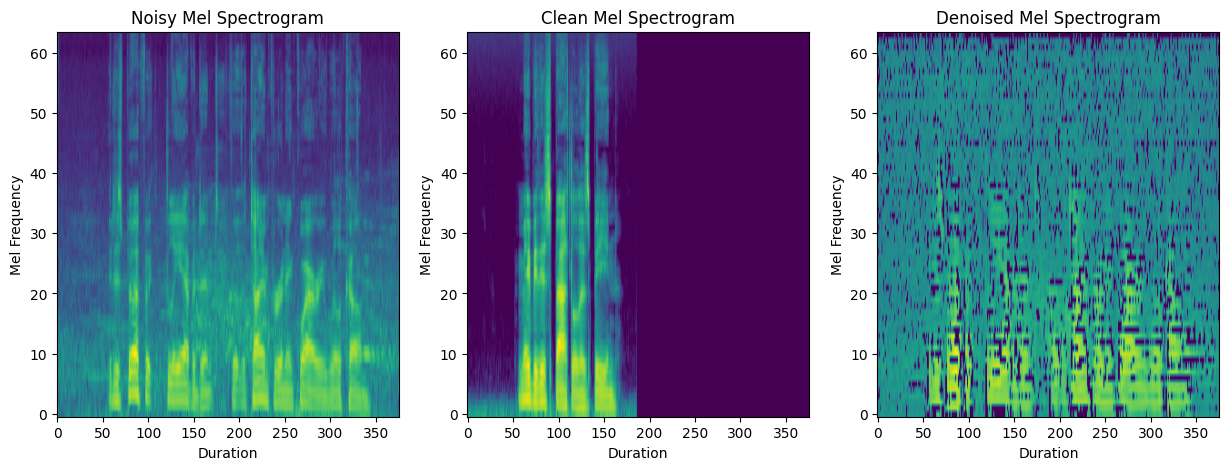

In [ ]:
import matplotlib.pyplot as plt

def show_mel_spectrograms(test_dataset, model, index, transform):
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        # Get the sample from the dataset
        clean, noisy = test_dataset[index]

        # Transform the noisy sample with the model
        denoised_output = model(noisy.unsqueeze(0)).squeeze(0)

        # Convert to numpy arrays for plotting
        noisy_mel_np = noisy.squeeze().numpy()
        clean_mel_np = clean.squeeze().numpy()
        denoised_mel_np = denoised_output.squeeze().numpy()
        print(f"Noisy Mel Spectrogram Size: {noisy_mel_np.shape}")
        print(f"Clean Mel Spectrogram Size: {clean_mel_np.shape}")
        print(f"Denoised Mel Spectrogram Size: {denoised_mel_np.shape}")

        # Plot the spectrograms
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot noisy spectrogram
        axes[0].imshow(librosa.power_to_db(noisy_mel_np, ref=np.max), aspect='auto', origin='lower')
        axes[0].set_title('Noisy Mel Spectrogram')

        axes[0].set_xlabel('Duration')
        axes[0].set_ylabel('Mel Frequency')

        # Plot clean spectrogram
        axes[1].imshow(librosa.power_to_db(clean_mel_np, ref=np.max), aspect='auto', origin='lower')
        axes[1].set_title('Clean Mel Spectrogram')
        axes[1].set_xlabel('Duration')
        axes[1].set_ylabel('Mel Frequency')

        # Plot denoised spectrogram
        axes[2].imshow(librosa.power_to_db(denoised_mel_np, ref=np.max), aspect='auto', origin='lower')
        axes[2].set_title('Denoised Mel Spectrogram')
        axes[2].set_xlabel('Duration')
        axes[2].set_ylabel('Mel Frequency')

        plt.show()

# Example usage
show_mel_spectrograms(test_dataset, model, index=5, transform=mel_spectrogram)

1 torch.Size([1, 64, 32, 188])
2 torch.Size([1, 128, 16, 94])
3 torch.Size([1, 256, 8, 47])
4 torch.Size([1, 256, 4, 23])
5 torch.Size([1, 256, 2, 11])
Noisy Mel Spectrogram Size: (64, 376)
Clean Mel Spectrogram Size: (64, 376)
Denoised Mel Spectrogram Size: (64, 376)


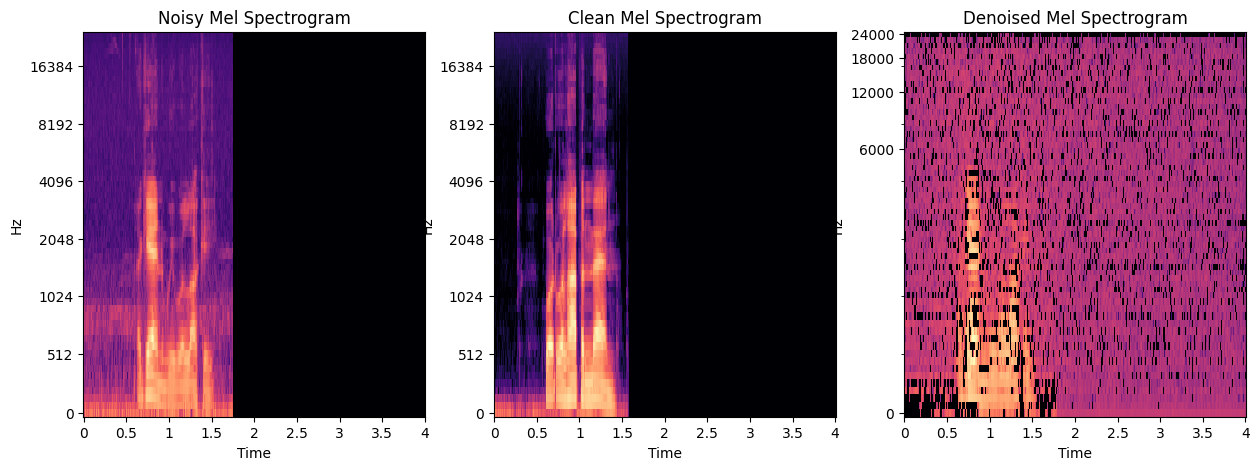

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def mel_to_hertz(mel_frequency):
    return 700 * (10**(mel_frequency / 2595) - 1)

def show_mel_spectrograms(test_dataset, model, index, transform):
    sample_rate = 48000  # Update the sample rate
    hop_length = 512  # Adjust hop length as needed

    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        # Get the sample from the dataset
        clean, noisy = test_dataset[index]

        # Transform the noisy sample with the model
        denoised_output = model(noisy.unsqueeze(0)).squeeze(0)

        # Convert to numpy arrays for plotting
        noisy_mel_np = noisy.squeeze().numpy()
        clean_mel_np = clean.squeeze().numpy()
        denoised_mel_np = denoised_output.squeeze().numpy()
        print(f"Noisy Mel Spectrogram Size: {noisy_mel_np.shape}")
        print(f"Clean Mel Spectrogram Size: {clean_mel_np.shape}")
        print(f"Denoised Mel Spectrogram Size: {denoised_mel_np.shape}")

        # Get the center frequencies of the Mel filterbank
        mel_filterbank_center_frequencies = librosa.mel_frequencies(n_mels=noisy_mel_np.shape[0], fmin=0, fmax=sample_rate//2)

        # Plot the spectrograms with Hertz labels
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot noisy spectrogram
        librosa.display.specshow(librosa.power_to_db(noisy_mel_np, ref=np.max), sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[0])
        axes[0].set_title('Noisy Mel Spectrogram')

        # Plot clean spectrogram
        librosa.display.specshow(librosa.power_to_db(clean_mel_np, ref=np.max), sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[1])
        axes[1].set_title('Clean Mel Spectrogram')

        # Plot denoised spectrogram
        librosa.display.specshow(librosa.power_to_db(denoised_mel_np, ref=np.max), sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[2])
        axes[2].set_title('Denoised Mel Spectrogram')

        # Add Hertz labels to the y-axis of the last subplot
        axes[2].set_yticks(np.linspace(0, mel_filterbank_center_frequencies[-1], 5))
        axes[2].set_yticklabels(map(int, np.linspace(0, mel_filterbank_center_frequencies[-1], 5)))

        plt.show()

# Example usage
show_mel_spectrograms(test_dataset, model, index=0, transform=mel_spectrogram)


In [ ]:
torch.load(model.state_dict(), f"/content/drive/MyDrive/denoise-model-res/aish.pth")

AttributeError: ignored

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/denoise-model-res/aish.pth"))

<All keys matched successfully>

In [ ]:
!pip3 install pesq
!pip install torchmetrics


  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262924 sha256=f60cd2488161a329863924b548d69eba09d5a890e7d87990d606986e04b89696
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.7 MB/s eta 0:00:00


In [ ]:
import math
from torchmetrics.audio import SignalDistortionRatio

def signalPower(x):
    # print(x)
    return np.average(x**2)
# def SNR(signal, noise):
#     powS = signalPower(signal)
#     powN = signalPower(noise)
#     return 10*math.log10(math.abs(powS-powN)/powN)
def SNRsystem(inputSig, outputSig):
    noise = outputSig-inputSig

    powS = signalPower(outputSig)
    powN = signalPower(noise)
    return 10*math.log10(abs((powS-powN))/powN)

def calculate_snr(clean_audio, noisy_audio):
    method2 = SNRsystem(clean_audio,noisy_audio)
    # print("Result Method 2: {} dB".format(method2))
    return method2

def calculate_sdr(clean_audio, noisy_audio):
  sdr = SignalDistortionRatio().to("cpu")
  sdr_calc = sdr(clean_audio, noisy_audio)
  return sdr_calc

In [ ]:
from IPython.display import Audio, display
import librosa
from pesq import pesq
def listen_to_denoised_audio(test_dataset, model, index, transform):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Get the sample from the dataset
        clean, noisy = test_dataset[index]

        # Denoise the noisy sample using the model
        denoised_output = model(noisy.unsqueeze(0)).squeeze(0)

        # Invert the Mel spectrogram to waveform

        clean_audio_np = librosa.feature.inverse.mel_to_audio(clean.squeeze().numpy(),
                                                              sr=config.target_sample_rate,
                                                              n_fft=config.n_fft,
                                                              hop_length=config.hop_length)


        noisy_audio_np = librosa.feature.inverse.mel_to_audio(noisy.squeeze().numpy(),
                                                              sr=config.target_sample_rate,
                                                              n_fft=config.n_fft,
                                                              hop_length=config.hop_length)
        denoised_audio_np = librosa.feature.inverse.mel_to_audio(denoised_output.squeeze().numpy(),
                                                                 sr=config.target_sample_rate,
                                                                 n_fft=config.n_fft,
                                                                 hop_length=config.hop_length)

        # Normalize audio for listening
        clean_audio_np = librosa.util.normalize(clean_audio_np)
        noisy_audio_np = librosa.util.normalize(noisy_audio_np)
        denoised_audio_np = librosa.util.normalize(denoised_audio_np)

        # Calculate SNR
        snr_og = calculate_snr(clean_audio_np, noisy_audio_np)
        print(f"snr_og: {snr_og}")
        pesq_og = pesq(16000, clean_audio_np, denoised_audio_np, 'wb')
        print(f"pesq_og: {pesq_og}")

        snr_pred = calculate_snr(clean_audio_np, denoised_audio_np)
        print(f"snr_pred: {snr_pred}")
        pesq_pred = pesq(16000, clean_audio_np, denoised_audio_np, 'wb')
        print(f"pesq_pred: {pesq_pred}")




        # Play the clean audio
        print("Clean Audio:")
        display(Audio(clean_audio_np, rate=config.target_sample_rate))

        # Play the original noisy audio
        print("Original Noisy Audio:")
        display(Audio(noisy_audio_np, rate=config.target_sample_rate))

        # Play the denoised audio
        print("Denoised Audio:")
        display(Audio(denoised_audio_np, rate=config.target_sample_rate))

# Example usage
listen_to_denoised_audio(test_dataset, model, index=1, transform=mel_spectrogram)


1 torch.Size([1, 64, 32, 188])
2 torch.Size([1, 128, 16, 94])
3 torch.Size([1, 256, 8, 47])
4 torch.Size([1, 256, 4, 23])
5 torch.Size([1, 256, 2, 11])
snr_og: -4.018906423822242
pesq_og: 1.0558336973190308
snr_pred: -3.6854642999242495
pesq_pred: 1.0558336973190308
Clean Audio:


Original Noisy Audio:


Denoised Audio:
